In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [95]:
# # Informações de conexão
# db_params = {
#   'user': 'postgres',
#   'password': 'postgres',
#   'host': 'localhost',
#   'dbname': 'GOALS',
# }

# # Conecta ao PostgreSQL
# conn = psycopg2.connect(**db_params)

# # Cria um cursor para executar comandos SQL
# cursor = conn.cursor()

# # Query Historico
# query = """SELECT * FROM futebol.match_history"""
# historico = pd.read_sql_query(query, conn)

In [96]:
historico = pd.read_excel('datasets/xlsx/historico.xlsx', index_col= 0)

In [97]:
historico = historico[(historico['season'] < 2023)]

In [98]:
gf_summary = historico.groupby(['comp'])['gf'].describe()

In [99]:
gf_summary.index

Index(['Brasileirao', 'Bundesliga', 'Premier League', 'Serie A'], dtype='object', name='comp')

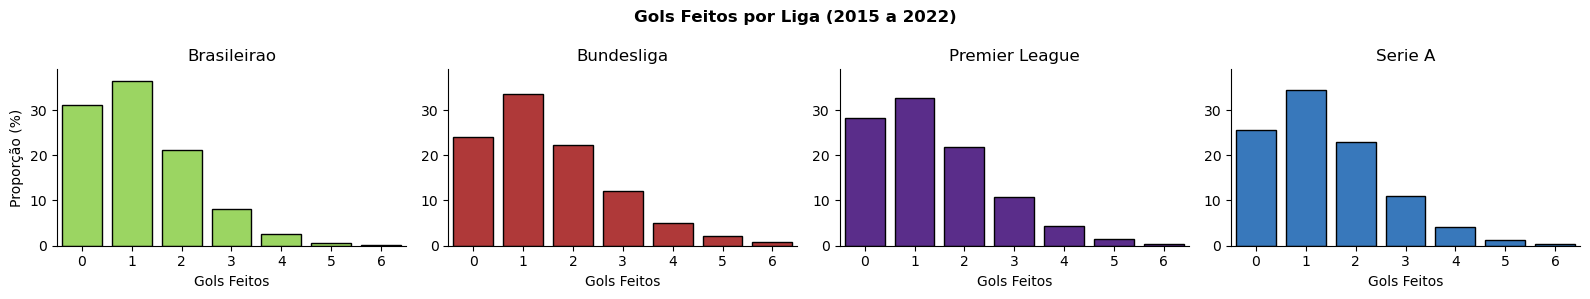

In [100]:
# Quantidade de ligas e suas cores
n_leagues = len(gf_summary.index)
colors_league = ['#9BE84F', '#C32525', '#591D99', '#2277D1']

# Gols feitos por ligas
fig, axes = plt.subplots(1, n_leagues, figsize= (16, 3))

for i, league in zip(range(n_leagues), gf_summary.index):
  sns.countplot(historico[historico['comp'] == league], x='gf', 
                stat= 'percent', ax= axes[i], color= colors_league[i], edgecolor= 'black')
  axes[i].set_ylim(0, 39)
  axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel("Gols Feitos")
  axes[i].set_title(league)
  if i > 0: 
    axes[i].set_ylabel("")

axes[0].set_ylabel("Proporção (%)")
plt.suptitle("Gols Feitos por Liga (2015 a 2022)", fontweight= 'bold')
plt.tight_layout()
plt.savefig('figures/analysis/gols-liga.png')
plt.show()


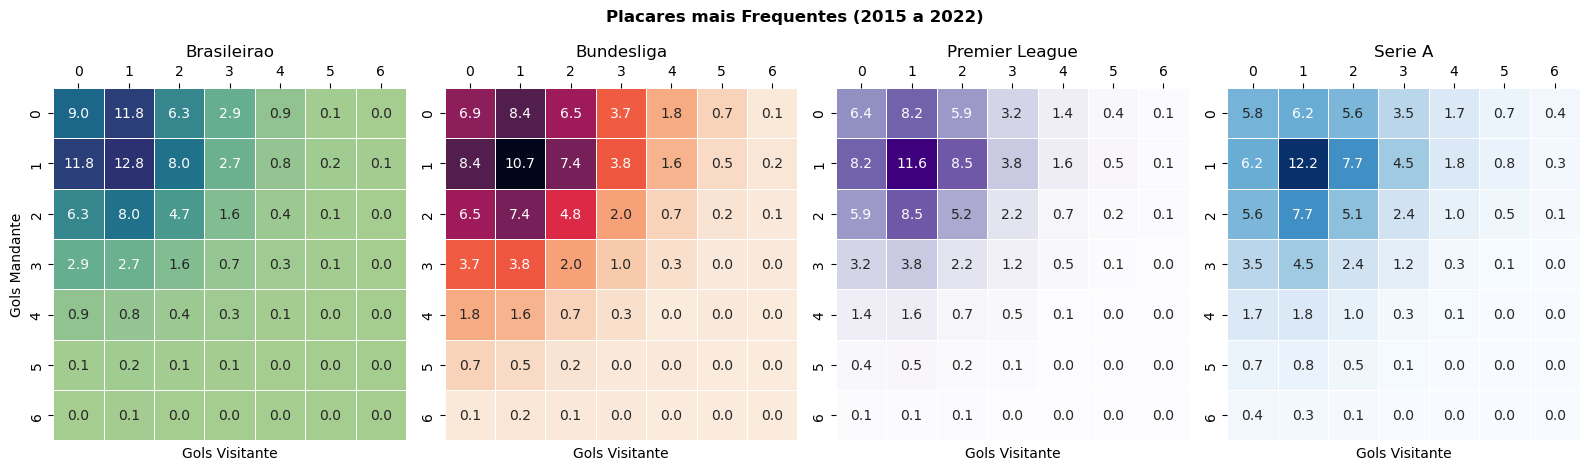

In [101]:
# Tabela de placares para cada liga
placares = []
for league in historico['comp'].unique():
  df = historico[historico['comp'] == league]
  df = pd.crosstab(df['gf'], df['ga'])
  df = (df/df.sum().sum())*100
  df = df.loc[:, df.columns <= 6]
  df = df.loc[df.index <= 6]
  placares.append(df)

# Cores das ligas
cores_cont = ['crest', 'rocket_r', 'Purples', 'Blues']

# Heatmap
fig, axes = plt.subplots(1, len(placares), figsize= (16, 5))
for i, league in zip(range(n_leagues), gf_summary.index):
  sns.heatmap(placares[i], annot=True, fmt='.1f', cmap= cores_cont[i], linewidth=.5, cbar= False, square= True, ax= axes[i])
  axes[i].xaxis.tick_top()
  axes[i].yaxis.tick_left()
  axes[i].set_xlabel("Gols Visitante")
  axes[i].set_ylabel("Gols Mandante")
  axes[i].set_title(league)
  if i > 0: 
    axes[i].set_ylabel("")

plt.suptitle("Placares mais Frequentes (2015 a 2022)", fontweight= 'bold')
plt.tight_layout()
plt.savefig('figures/analysis/placar-liga.png')
plt.show()

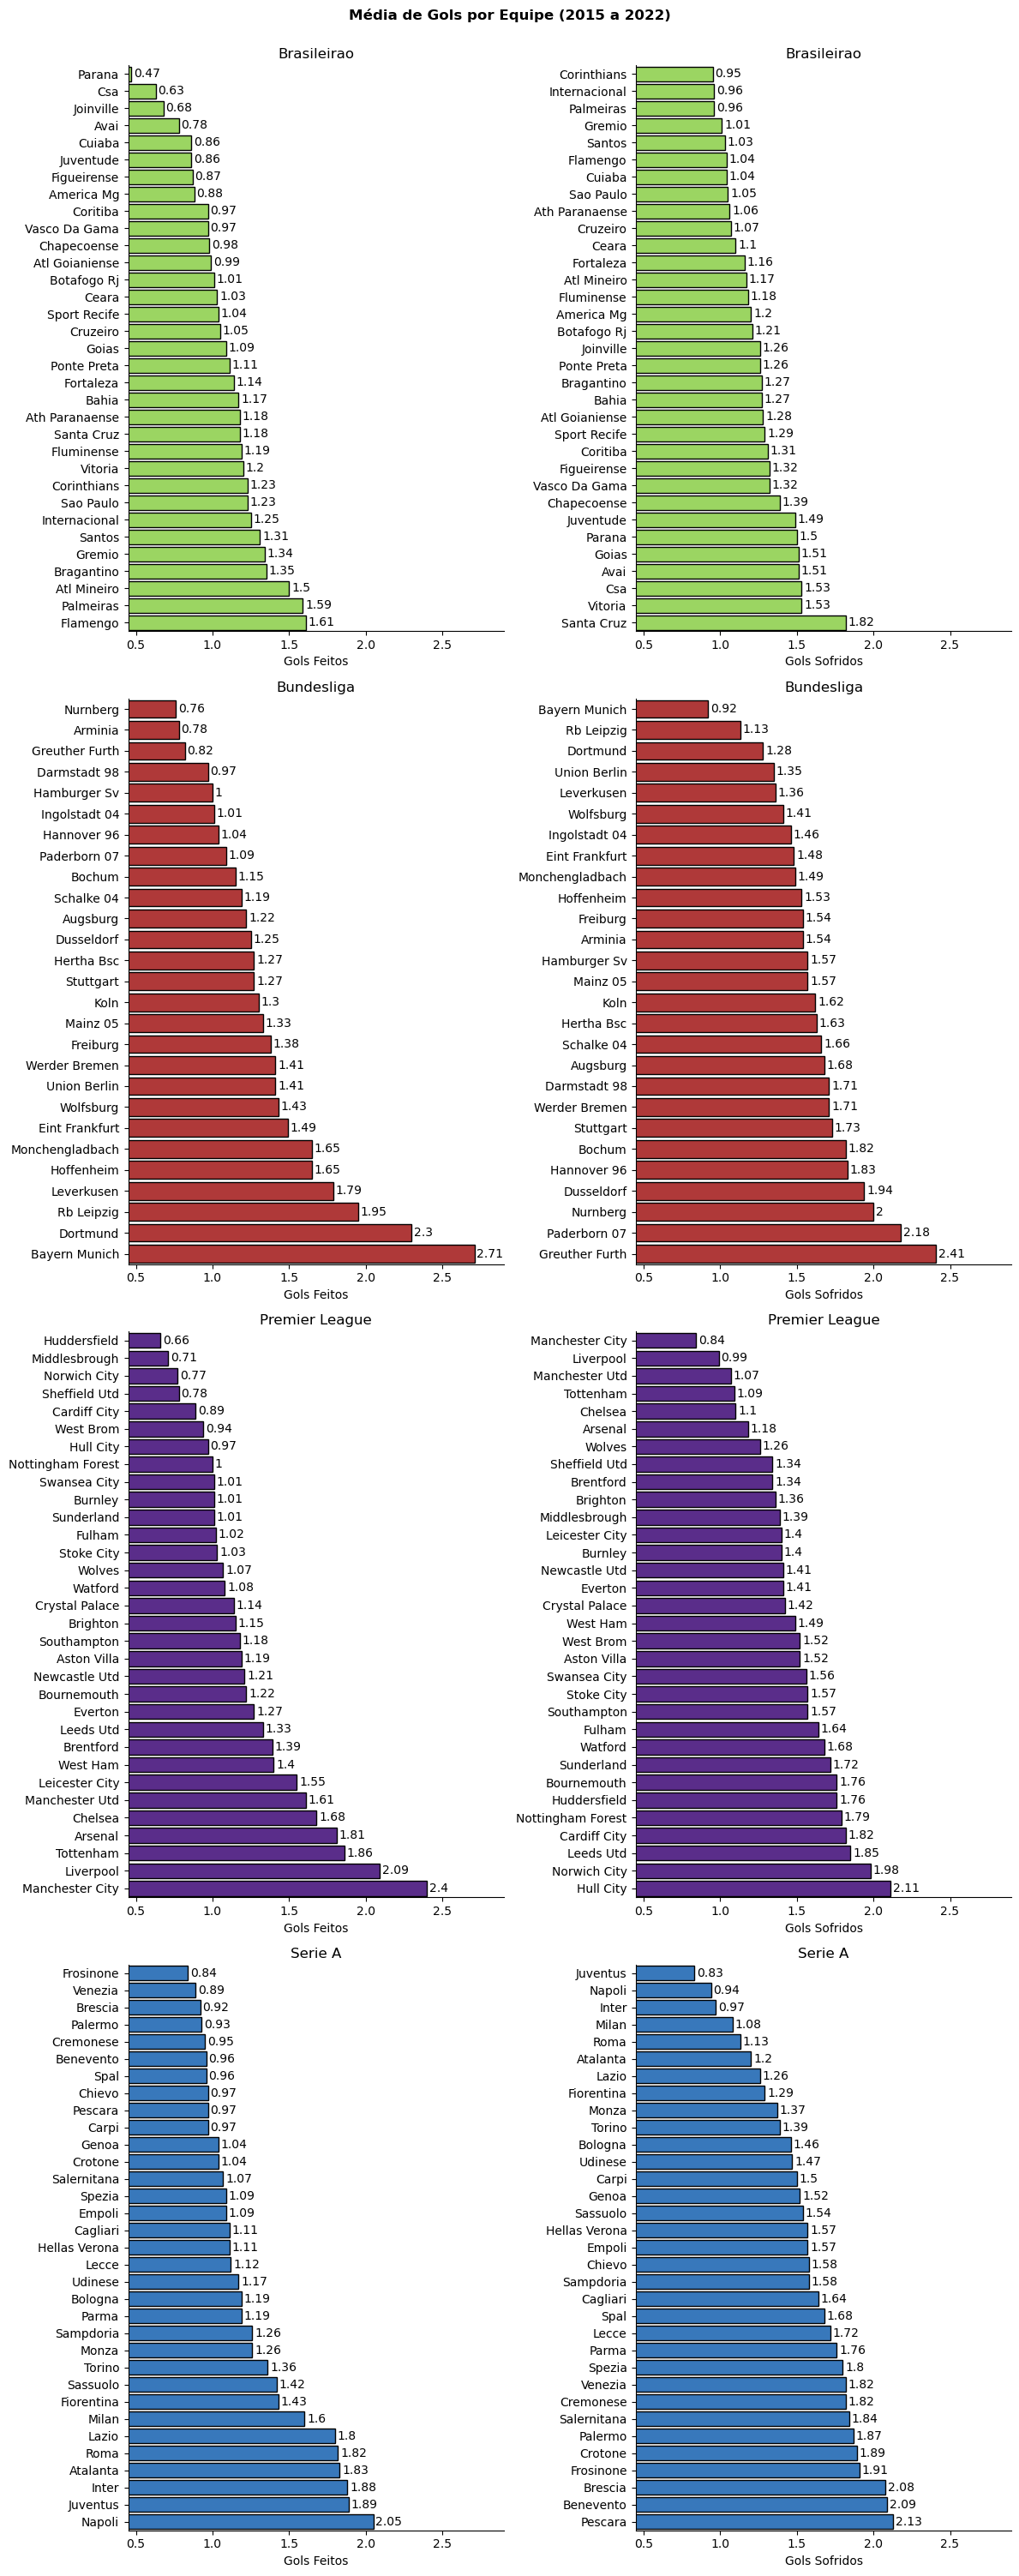

In [102]:
# Média de gols por time
gf_team = historico.groupby(['team', 'comp'])['gf'].aggregate('mean').reset_index().sort_values('gf').round(2)
gf_team['team'] = gf_team['team'].str.replace('_', ' ').str.title()
gf_team['g'] = gf_team['gf']

ga_team = historico.groupby(['team', 'comp'])['ga'].aggregate('mean').reset_index().sort_values('ga').round(2)
ga_team['team'] = ga_team['team'].str.replace('_', ' ').str.title()
ga_team['g'] = ga_team['ga']

gf = [gf_team, ga_team]


# Grafico
fig, axes = plt.subplots(4, 2, figsize= (12, 30))

for i, league in enumerate(gf_summary.index):
  for c, col in enumerate(gf):
    sns.barplot(col[col['comp'] == league], x= 'g', y= 'team', 
                errorbar= None, edgecolor= 'black', width= 0.85, color= colors_league[i], ax= axes[i, c])
    axes[i, c].bar_label(axes[i, c].containers[0], fontsize= 10, padding= 2)
    axes[i, c].set_xlim(0.45, 2.9)
    axes[i, c].tick_params(axis= 'y', direction='out', pad= 4)
    axes[i, c].set_ylabel('')
    axes[i, c].set_title(league)
    axes[i, c].spines['top'].set_visible(False)
    axes[i, c].spines['right'].set_visible(False)
    if c == 0:
      axes[i, c].set_xlabel('Gols Feitos')
    else:
      axes[i, c].set_xlabel('Gols Sofridos')

plt.suptitle("Média de Gols por Equipe (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/media_gols-liga.png')
plt.show()


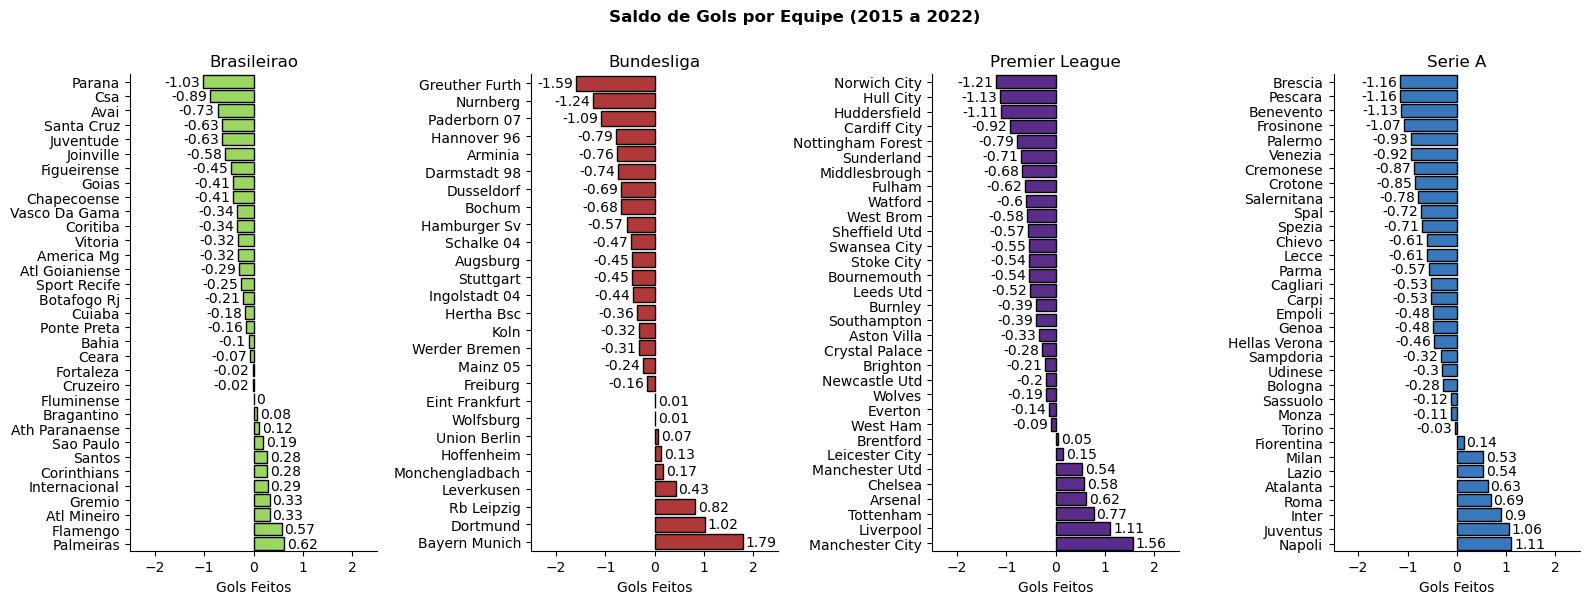

In [103]:
# Saldo de gols por time
historico['g_diff'] = historico['gf'] - historico['ga']
gd_team = historico.groupby(['team', 'comp'])['g_diff'].aggregate('mean').reset_index().sort_values('g_diff').round(2)
gd_team['team'] = gd_team['team'].str.replace('_', ' ').str.title()

# Grafico
fig, axes = plt.subplots(1, len(gf_summary.index), figsize= (16, 6))

for i, league in enumerate(gf_summary.index):
    sns.barplot(gd_team[gd_team['comp'] == league], x= 'g_diff', y= 'team', 
                errorbar= None, edgecolor= 'black', width= 0.85, color= colors_league[i], ax= axes[i])
    axes[i].bar_label(axes[i].containers[0], fontsize= 10, padding= 2)
    axes[i].set_xlim(-2.5, 2.5)
    axes[i].tick_params(axis= 'y', direction='out', pad= 4)
    axes[i].set_ylabel('')
    axes[i].set_title(league)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('Gols Feitos')

plt.suptitle("Saldo de Gols por Equipe (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/saldo_gols-liga.png')
plt.show()


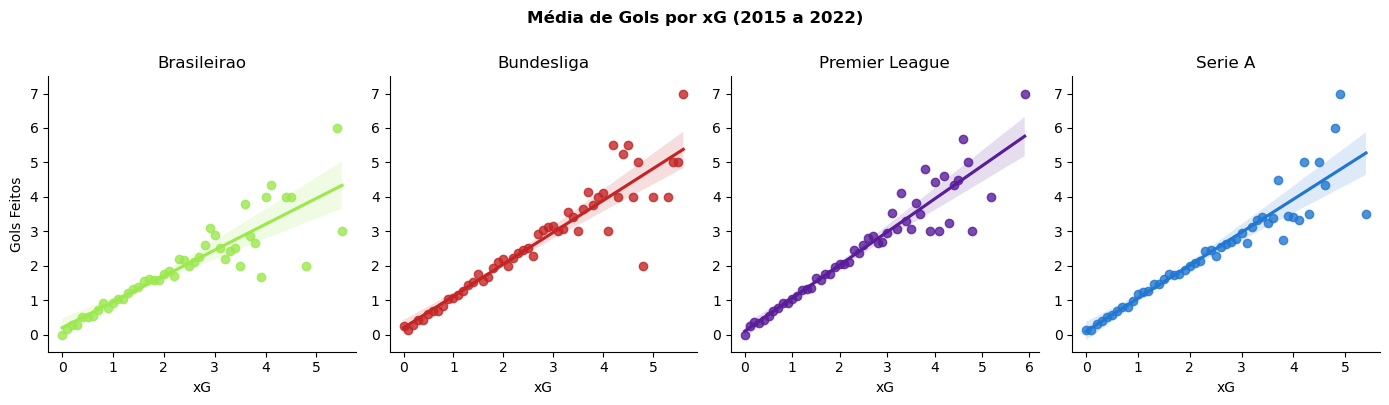

In [104]:
# Média de gols por xG
xg_gf = historico.groupby(['xg', 'comp'])['gf'].aggregate('mean').reset_index()

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 4))

for i, league in enumerate(gf_summary.index):
  sns.regplot(xg_gf[xg_gf['comp'] == league], y= 'gf', x= 'xg', color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].set_ylim(-0.5, 7.5)
  #axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('xG')
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Gols Feitos')

plt.suptitle("Média de Gols por xG (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/xg_gols-liga.png')
plt.show()


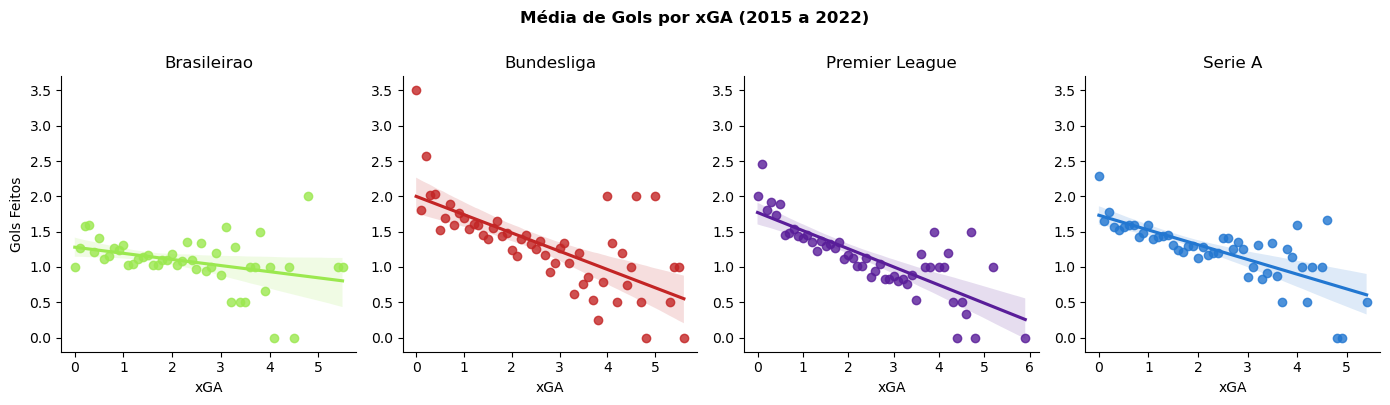

In [105]:
# Média de gols por xGA
xga_gf = historico.groupby(['xga', 'comp'])['gf'].aggregate('mean').reset_index()

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 4))

for i, league in enumerate(gf_summary.index):
  sns.regplot(xga_gf[xga_gf['comp'] == league], y= 'gf', x= 'xga', color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].set_ylim(-0.2, 3.7)
  #axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('xGA')
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Gols Feitos')

plt.suptitle("Média de Gols por xGA (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/xga_gols-liga.png')
plt.show()


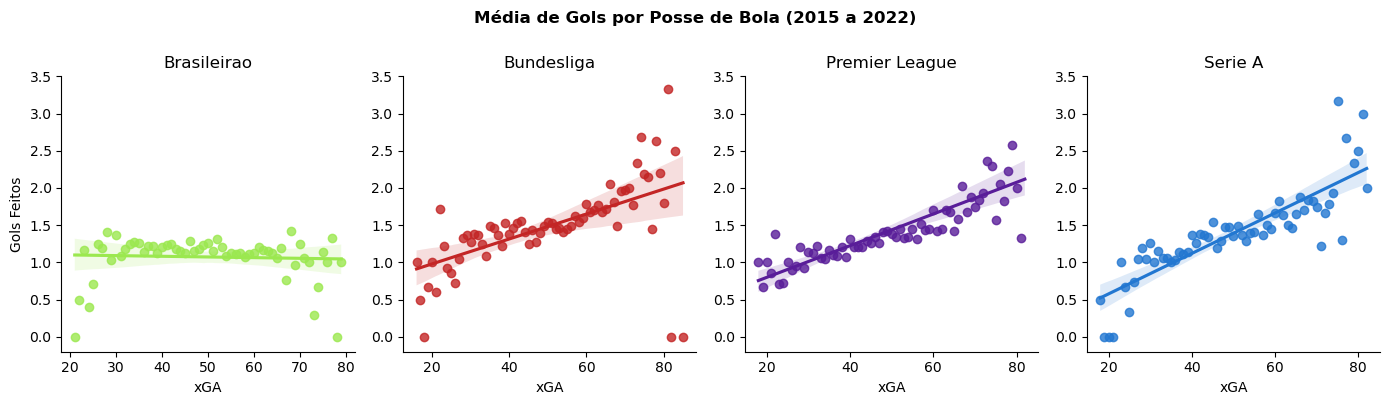

In [106]:
# Média de gols por Posse de bola
poss_gf = historico.groupby(['poss', 'comp'])['gf'].aggregate('mean').reset_index()

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 4))

for i, league in enumerate(gf_summary.index):
  sns.regplot(poss_gf[poss_gf['comp'] == league], y= 'gf', x= 'poss', color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].set_ylim(-0.2, 3.5)
  #axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('xGA')
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Gols Feitos')

plt.suptitle("Média de Gols por Posse de Bola (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/poss_gols-liga.png')
plt.show()


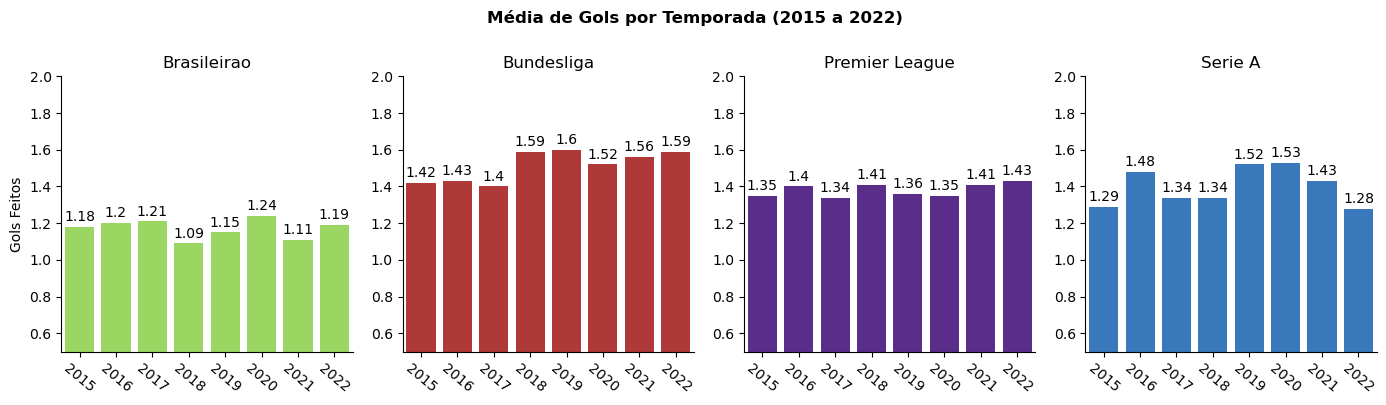

In [107]:
# Média de gols por Temporada
season_gf = historico.groupby(['season', 'comp'])['gf'].aggregate('mean').reset_index()
season_gf['gf'] = season_gf['gf'].round(2)

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 4))

for i, league in enumerate(gf_summary.index):
  sns.barplot(season_gf[season_gf['comp'] == league], y= 'gf', x= 'season', color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].set_ylim(0.5, 2)
  axes[i].bar_label(axes[i].containers[0], fontsize= 10, padding= 2)
  #axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('')
  axes[i].tick_params(axis='x', labelrotation = -40)
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Gols Feitos')

plt.suptitle("Média de Gols por Temporada (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/mean_gols-liga.png')
plt.show()


Venue, sh, sot, saves, touches_att_3rd
xgdiff
poss por time


cmp, cmp-att,       # Passes completados, passes tentados
prgp                 #Progressive Passes
sw                   # Virada de jogo
crs                  # cruzamentos
pass_3rd


sca, gca #Shot and gols creation actions


tkl, tklw, tklw-tkl
tkl_def_3rd, tkl_att_3rd
blocks, int
fls
off
revov